/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


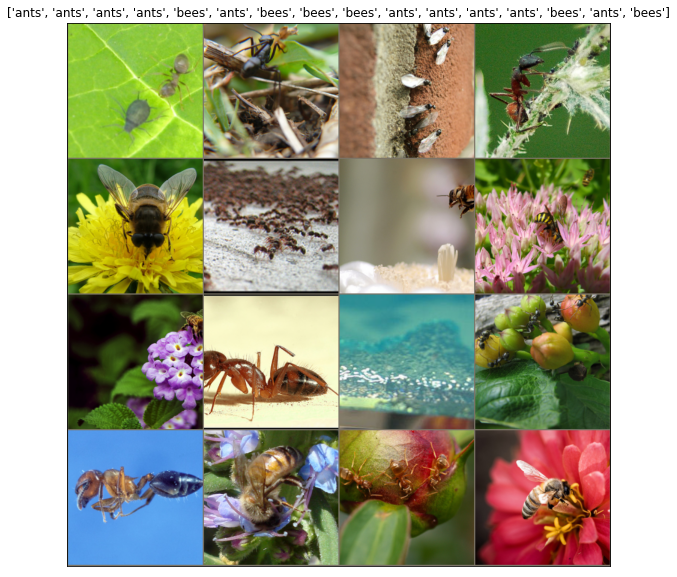

In [1]:

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# visualize
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)


In [2]:
# model train
import psutil

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device = device):
    time_start = time.perf_counter()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = (time.perf_counter() - time_start)
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss/1024.0/1024.0
    print("report mem usage %5.3f MB" % mem)
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

# only validation
def validation_model(model, criterion, optimizer, device):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    time_start = time.perf_counter()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    time_elapsed = (time.perf_counter() - time_start)
    
    val_acc = running_corrects.double() / dataset_sizes['val']
    print('Test accuracy: {:4f}'.format(val_acc))
    
    print('Inference complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss/1024.0/1024.0
    print("report mem usage %5.3f MB" % mem)
    
    q=print_size_of_model(model,"ResNet")
    

    
def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)
    

In [3]:
import torchvision.models.quantization as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

torch.save(model.state_dict(),'./models/res18_ab.pt')

# Step 1
model.train()
model.fc = nn.Linear(num_ftrs, 2)
model = model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1, device = 'cpu')
validation_model(model, criterion, optimizer_ft,'cpu')

torch.save(model.state_dict(),'./models/res18_ab.pt')


Epoch 0/0
----------
train Loss: 0.5524 Acc: 0.7049
val Loss: 0.3262 Acc: 0.8824

Training complete in 2m 44s
report mem usage 398.832 MB
Best val Acc: 0.882353
Test accuracy: 0.882353
Inference complete in 1m 0s
report mem usage 279.707 MB
model:  ResNet  	 Size (KB): 44787.341


In [4]:
# static

model.load_state_dict(torch.load('./models/res18_ab.pt'))
model_fp32 = copy.deepcopy(model)
model_fp32.eval()
model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')
print(model_fp32)
model_fp32 = torch.quantization.fuse_modules(model_fp32,[["conv1","bn1","relu"]],inplace=True)

for module_name, module in model_fp32.named_children():
    if "layer" in module_name:
        for basic_block_name, basic_block in module.named_children():
            torch.quantization.fuse_modules(
                basic_block, [["conv1", "bn1", "relu"], ["conv2", "bn2"]],
                inplace=True)
            for sub_block_name, sub_block in basic_block.named_children():
                if sub_block_name == "downsample":
                    torch.quantization.fuse_modules(sub_block,[["0", "1"]],inplace=True)

print(model_fp32)


QuantizableResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_relu): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): QuantizableBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, e

In [5]:
model_fp32_pre = torch.quantization.prepare(model_fp32)

#### Prepare the model
# with torch.no_grad():
#     for inputs, labels in dataloaders['train']:
#         inputs = inputs.to('cpu')
#         model_fp32_pre(inputs)
# validation_model(model_fp32, criterion, optimizer_ft,'cpu')

model_int8 = torch.quantization.convert(model_fp32_pre)
validation_model(model_int8, criterion, optimizer_ft,'cpu')


/opt/anaconda3/lib/python3.8/site-packages/torch/ao/quantization/observer.py:172: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torch/ao/quantization/observer.py:1107: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


Test accuracy: 0.457516
Inference complete in 0m 58s
report mem usage 252.719 MB
model:  ResNet  	 Size (KB): 11308.193
